In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import matplotlib as mpl
from tqdm.notebook import tqdm

In [2]:
@jit(nopython=True)
def RK4_ZZ(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    Etheta = np.exp(1j*y0)
    Na,_,_,_ = args
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y[i], t[i], *args)
        k2,_,_,_,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return y,(Z1as,Z1bs,Z2as,Z2bs)

def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    Etheta = np.exp(1j*y0)

    y[0] = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

@jit(nopython=True)
def get_ZE12(Etheta):
    ''' get theta and return r and theta'''
    E1 = Etheta
    E2 = E1**2
    Z1,Z2 = np.mean(E1),np.mean(E2)
    return Z1,Z2

# @jit(nopython=True)
# def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,a,alpha):
#     dtheta = np.zeros(Na+Nb)

#     Etheta = np.exp(1j*Theta)
#     EA,EB = Etheta[:Na],Etheta[Na:]
#     Z1a,Z2a = get_ZE12(EA)
#     Z1b,Z2b = get_ZE12(EB)
#     A = np.exp(-1j*alpha)
#     EA,EB = np.conjugate(EA), np.conjugate(EB)
#     ZZa =  (Z1a+a*Z1b)
#     ZZb =  (Z1b+a*Z1a)
#     dtheta[:Na] = ((A*(ZZa**2-Z2a/Na - a*Z2b/Nb))*EA*EA -(2*A/Na*ZZa)*EA).imag
#     dtheta[Na:] = ((A*(ZZb**2-Z2b/Nb - a*Z2a/Na))*EB*EB -(2*A/Nb*ZZb)*EB).imag
#     return dtheta,Z1a,Z1b,Z2a,Z2b

@jit(nopython=True)
def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,a,alpha):
    dtheta = np.zeros(Na+Nb)

    Etheta = np.exp(1j*Theta)
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    A = np.exp(-1j*alpha)
    EA,EB = np.conjugate(EA), np.conjugate(EB)
    ZZa =  (Z1a+a*Z1b)
    ZZb =  (Z1b+a*Z1a)
    dtheta[:Na] = ((A*(ZZa**2))*EA*EA).imag
    dtheta[Na:] = ((A*(ZZb**2))*EB*EB).imag
    return dtheta,Z1a,Z1b,Z2a,Z2b

0.031999998 2.5744495e-15


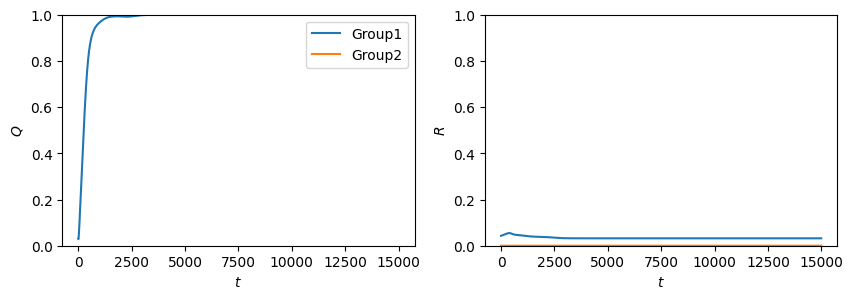

In [151]:
t = np.arange(0,15000,0.05)
# t = t*10
a = 0.3
alpha = 1.2

N1 = N2 = 500
Nt = N1+N2
R2,R1 = 0,0
Q2,Q1 = 0,0
num = 0
R1s,R2s = [], []
Q1s,Q2s = [], []

while (Q1<0.4) and (Q2<0.4):
    Theta = np.random.uniform(0,2*np.pi,Nt)
    Theta[N1:N1+N2//2] = np.zeros(N2//2)
    Theta[N1+N2//2:] = np.zeros(N2//2) +np.pi
    sol,(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ(Kuramoto_MF_CHIMERA,Theta,t,args=(N1,N2,a,alpha))
    R1 = np.abs(Z1as[-1])
    R2 = np.abs(Z1bs[-1])
    Q1 = np.abs(Z2as[-1])
    Q2 = np.abs(Z2bs[-1])
    R1s.append(R1)
    R2s.append(R2)
    Q1s.append(Q1)
    Q2s.append(Q2)
    print(R1,R2)
    num+=1 

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(t,abs(Z2as),label='Group1')
plt.plot(t,abs(Z2bs),label='Group2')
plt.legend()
plt.ylabel(r'$Q$')
plt.xlabel(r'$t$')
plt.ylim(0,1)
plt.subplot(122)
plt.plot(t,abs(Z1as))
plt.plot(t,abs(Z1bs))
plt.ylabel(r'$R$')
plt.xlabel(r'$t$')
plt.ylim(0,1)

plt.show()

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        , 1.10000002, 1.20000005, 1.29999995, 1.39999998,
        1.5       ]),
 <BarContainer object of 10 artists>)

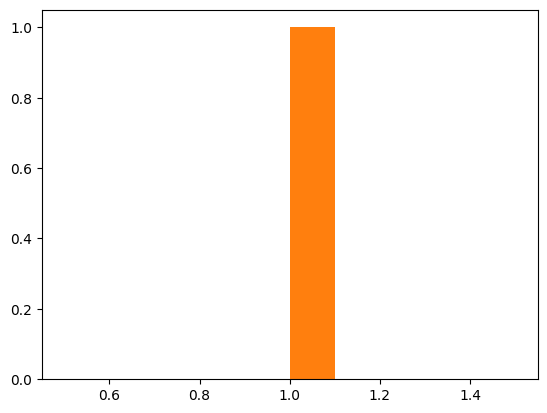

In [152]:
plt.hist(Q2s)
plt.hist(Q1s)

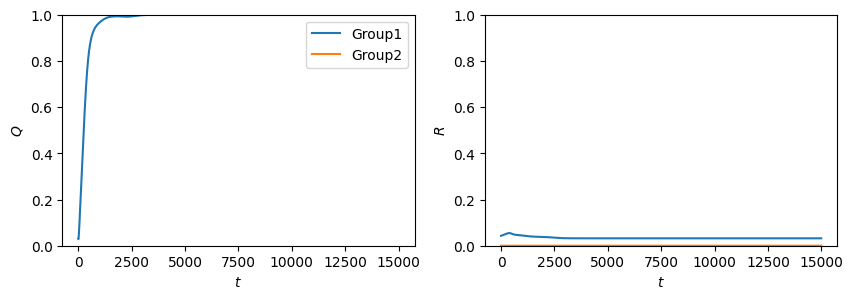

In [153]:

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(t,abs(Z2as),label='Group1')
plt.plot(t,abs(Z2bs),label='Group2')
plt.legend()
plt.ylabel(r'$Q$')
plt.xlabel(r'$t$')
plt.ylim(0,1)
plt.subplot(122)
plt.plot(t,abs(Z1as))
plt.plot(t,abs(Z1bs))
plt.ylabel(r'$R$')
plt.xlabel(r'$t$')
plt.ylim(0,1)

plt.show()

In [154]:
theta1s =  sol[:,:N1]
theta2s = sol[:,N1:]

In [155]:
sol[:,:N1]

array([[  2.83903774,   5.88821424,   0.42698701, ...,   4.25201885,
          0.24540702,   6.24703966],
       [  2.83894611,   5.88812555,   0.42696938, ...,   4.25210364,
          0.24535849,   6.24695694],
       [  2.83885448,   5.88803685,   0.42695176, ...,   4.25218844,
          0.24530996,   6.24687421],
       ...,
       [-12.66146853,  -9.51987589, -12.66146879, ...,  -9.51987599,
        -12.66146935,  -9.51987577],
       [-12.66151625,  -9.51992361, -12.66151651, ...,  -9.51992371,
        -12.66151707,  -9.51992349],
       [-12.66156397,  -9.51997133, -12.66156423, ...,  -9.51997143,
        -12.66156479,  -9.51997121]])

In [156]:
theta1 =  sol[-1,:N1]
theta2 = sol[-1,N1:]
# plt.plot(sol[-1,:100])

In [157]:
Z1 = theta1
arg1a, = np.where(Z1%(np.pi*2)<np.pi)
arg1b, = np.where(Z1%(np.pi*2)>=np.pi)
A1 = np.where(Z1%(np.pi*2)<np.pi,np.nan,Z1)
B1 = np.where(Z1%(np.pi*2)>=np.pi,np.nan,Z1)
A1 = A1[~np.isnan(A1)]
B1 = B1[~np.isnan(B1)]

Z2 = theta2
arg2a, = np.where(Z2%(np.pi*2)<np.pi)
arg2b, = np.where(Z2%(np.pi*2)>=np.pi)
A2 = np.where(Z2%(np.pi*2)<np.pi,np.nan,Z2)
B2 = np.where(Z2%(np.pi*2)>=np.pi,np.nan,Z2)
A2 = A2[~np.isnan(A2)]
B2 = B2[~np.isnan(B2)]

print(len(A1),len(A2),len(B1),len(B2))

258 250 242 250


In [158]:
Az1 = 2/N1*(np.sum(np.exp(A1*1j)))
Bz1 = 2/N1*(np.sum(np.exp(B1*1j)))
Az2 = 2/N2*(np.sum(np.exp(A2*1j)))
Bz2 = 2/N2*(np.sum(np.exp(B2*1j)))

In [159]:
np.angle(Az1) - np.angle(Az2)

-0.055180403584300396

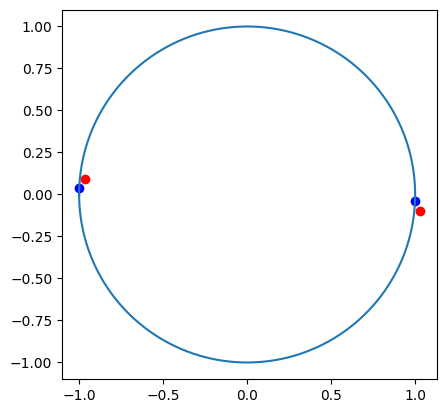

In [160]:
plt.gca().set_aspect(1)
plt.scatter(Az1.real,Az1.imag,color='red')
plt.scatter(Bz1.real,Bz1.imag,color='red')

plt.scatter(Az2.real,Az2.imag,color='blue')
plt.scatter(Bz2.real,Bz2.imag,color='blue')
x_ = np.linspace(-np.pi,np.pi,1000)
plt.plot(np.cos(x_),np.sin(x_))

In [161]:
theta1as = theta1s[:,arg1a]
theta1bs = theta1s[:,arg1b]

theta2as = theta2s[:,arg2a]
theta2bs = theta2s[:,arg2b]

In [162]:
Z2As = 1/N1*(np.sum(np.exp(2j*theta1s),axis=(1)))
Z2Bs = 1/N1*(np.sum(np.exp(2j*theta2s),axis=(1)))

In [163]:
Z1As = 1/N1*(np.sum(np.exp(theta1s*1j),axis=(1)))
Z1Bs = 1/N1*(np.sum(np.exp(theta2s*1j),axis=(1)))

In [164]:
Az1s = 2/N1*(np.sum(np.exp(theta1as*1j),axis=(1)))
Bz1s = 2/N1*(np.sum(np.exp(theta1bs*1j),axis=(1)))
Az2s = 2/N2*(np.sum(np.exp(theta2as*1j),axis=(1)))
Bz2s = 2/N2*(np.sum(np.exp(theta2bs*1j),axis=(1)))

In [165]:
r1a = np.abs(Az1s)
r1a_deg = np.angle(Az1s)
r1b = np.abs(Bz1s)
r1b_deg = np.angle(Bz1s)


r2a = np.abs(Az2s)
r2a_deg = np.angle(Az2s)
r2b = np.abs(Bz2s)
r2b_deg = np.angle(Bz2s)

QA = np.abs(Z2As)
QB = np.abs(Z2Bs)
QA_deg = np.angle(Z2As)
QB_deg = np.angle(Z2Bs)

r1as,r1bs,r2as,r2bs = r1a,r1b,r2a,r2b


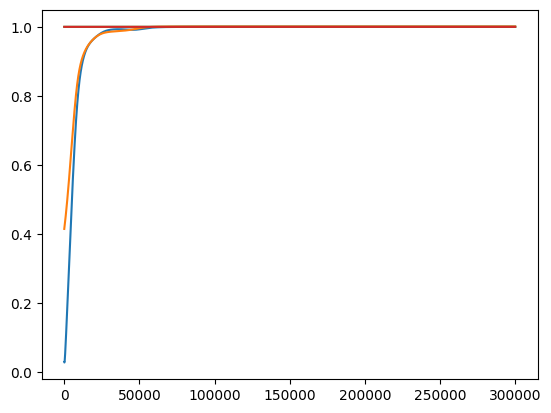

In [166]:
plt.plot(QA)
plt.plot(r1a**2/2+r1b**2/2)
plt.plot(QB)
plt.plot(r2a**2/2+r2b**2/2)

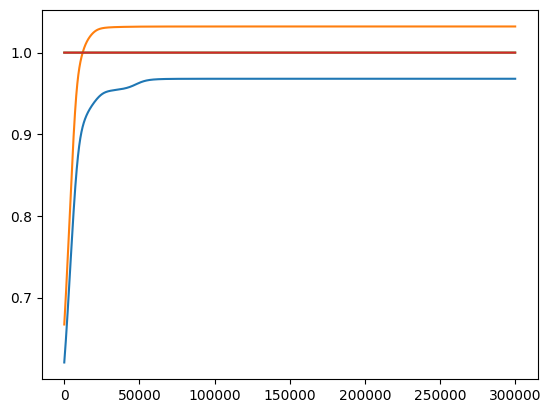

In [167]:
plt.plot(r1a)
plt.plot(r1b)
plt.plot(r2a)
plt.plot(r2b)

ValueError: x and y must have same first dimension, but have shapes (100000,) and (300000,)

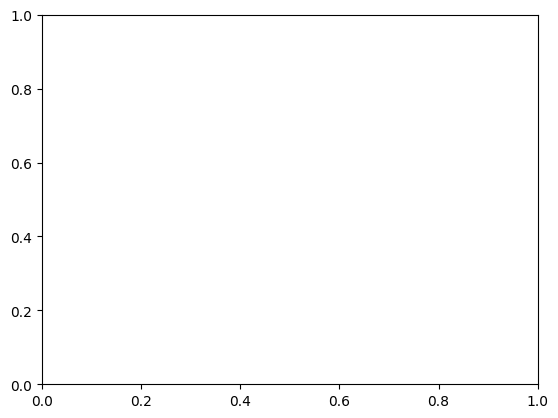

In [142]:
plt.plot(t,r1a_deg - r2a_deg)


## 이론으로 시뮬레이션

In [25]:
alpha = 0.1
beta = 0.3
K = 1
phi = 1

def drphi(Dsr,t,alpha,beta):
    r1a,r1b,r2a,r2b,phi = Dsr
    R1 =r1a -r1b
    R2 =r2a -r2b
    HH1 =  (R1**2 *np.cos(alpha) +(beta*R1)**2 *np.cos(alpha + 2*phi) +2*(beta*R1*R2) *np.cos(alpha + phi))
    HH2 =  (R2**2 *np.cos(alpha) +(beta*R2)**2 *np.cos(alpha - 2*phi) +2*(beta*R1*R2) *np.cos(alpha - phi))

    HH1_s =  (R1**2 *np.sin(alpha) +(beta*R1)**2 *np.sin(alpha + 2*phi) +2*(beta*R1*R2) *np.sin(alpha + phi))
    HH2_s =  (R2**2 *np.sin(alpha) +(beta*R2)**2 *np.sin(alpha - 2*phi) +2*(beta*R1*R2) *np.sin(alpha - phi))

    dr_1a = K/8 * r1a *(1-r1a**2) *HH1
    dr_1b = K/8 * r1b *(1-r1b**2) *HH1
    dr_2a = K/8 * r2a *(1-r2a**2) *HH2
    dr_2b = K/8 * r2b *(1-r2b**2) *HH2
    dphi = K/8 * (1+r1a**2) * HH2_s - K/8 * (1+r2a**2) * HH1_s 
    Ds = np.array([dr_1a,dr_1b,dr_2a,dr_2b,dphi])
    return Ds


In [26]:
(r1a_deg - r2a_deg)[0]

-2.119804644816761

In [190]:
eps = 0.1
r1a = 1
r1b = 1
r2a = 0.7
r2b = 0.4

# r1a = r1as[0]
# r1b = r1bs[0]
# r2a = r2as[0]
# r2b = r2bs[0]
phi = 1
Ds = np.array([r1a,r1b,r2a,r2b,phi])

In [191]:
Ds

array([1. , 1. , 0.7, 0.4, 1. ])

In [192]:
a = 0.3
alpha = 1.2

In [206]:
alpha = 0.5
beta = 0.8
t = np.arange(0,50000,0.5)
r1as_a,r1bs_a,r2as_a,r2bs_a,phis = RK4(drphi,Ds,t,args=(alpha,beta)).T

In [207]:
q1s = (r1as_a**2 + r1bs_a**2)/2
q2s = (r2as_a**2 + r2bs_a**2)/2

r1s = (r1as_a - r1bs_a)/2
r2s = (r2as_a - r2bs_a)/2


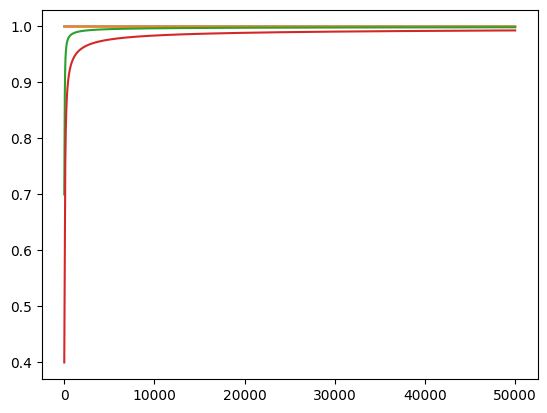

In [208]:
plt.plot(t,r1as_a)
plt.plot(t,r1bs_a)
plt.plot(t,r2as_a)
plt.plot(t,r2bs_a)
# plt.plot(t,phis)

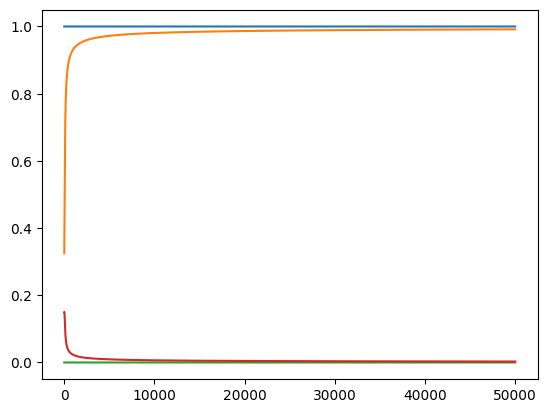

In [209]:
plt.plot(t,q1s)
plt.plot(t,q2s)

plt.plot(t,r1s)
plt.plot(t,r2s)

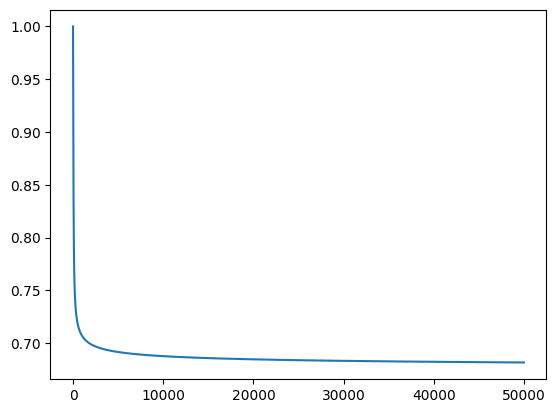

In [210]:
plt.plot(t,phis)

In [ ]:
.